<a href="https://colab.research.google.com/github/yazan225/ML_Proj/blob/master/FinalMachineLearningProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project ( Image Classification Using MoblieNetv2 )

# ** Step 1 **

In [1]:
# Install dependencies
!pip install tensorflow keras matplotlib scikit-learn seaborn kaggle

import os
import zipfile
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import cv2
from tqdm import tqdm


# ** Step 2 **

In [2]:
## Step 2: Download and Extract Dataset
from google.colab import files
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d alessiocorrado99/animals10

with zipfile.ZipFile('animals10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 586M/586M [00:27<00:00, 24.5MB/s]
100% 586M/586M [00:27<00:00, 22.5MB/s]


# ** Step 3 **

In [3]:
# ## Step 3: Splitting the data into train, val, test
source_dir = "animals10/raw-img"
output_dir = "SplittedAnimals10"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data
def split_and_transfer_data():
    for animal_class in os.listdir(source_dir):
        class_path = os.path.join(source_dir, animal_class)

        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)

        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)  # 70% train # you'll get the exact same split of the data with random_state=42
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 15% val, 15% test

        os.makedirs(os.path.join(train_dir, animal_class), exist_ok=True)
        os.makedirs(os.path.join(val_dir, animal_class), exist_ok=True)
        os.makedirs(os.path.join(test_dir, animal_class), exist_ok=True)

        for img in train_images:
            # copying an image file (img) from its source directory (class_path) to a target directory.
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, animal_class, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, animal_class, img))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, animal_class, img))

        print(f"Processed class: {animal_class}")
    print("Data transfer complete.")

split_and_transfer_data()

Processed class: gallina
Processed class: mucca
Processed class: cavallo
Processed class: ragno
Processed class: farfalla
Processed class: elefante
Processed class: gatto
Processed class: scoiattolo
Processed class: cane
Processed class: pecora
Data transfer complete.


# ** Step 4 **

In [4]:
# Step 4: Defines and trains a model using MobileNetV2 & applying data augmentation for training
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False
model = Model(inputs=base_model.input,
              outputs=Dense(10, activation='softmax')(GlobalAveragePooling2D()(base_model.output)))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the data generators with image resizing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/SplittedAnimals10/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    '/content/SplittedAnimals10/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    '/content/SplittedAnimals10/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 18322 images belonging to 10 classes.
Found 3926 images belonging to 10 classes.
Found 3931 images belonging to 10 classes.


# ** Step 5 **

In [13]:
# Step 5: Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ** Step 6 **

In [6]:
# Step 6: Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


573/573 ━━━━━━━━━━━━━━━━━━━━ 141s 221ms/step - accuracy: 0.1321 - loss: 2.7526 - val_accuracy: 0.1992 - val_loss: 2.2649
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 123s 212ms/step - accuracy: 0.2305 - loss: 2.1960 - val_accuracy: 0.3816 - val_loss: 1.8215
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 130s 225ms/step - accuracy: 0.3912 - loss: 1.8105 - val_accuracy: 0.5331 - val_loss: 1.4910
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 131s 227ms/step - accuracy: 0.5000 - loss: 1.5495 - val_accuracy: 0.6350 - val_loss: 1.2457
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 117s 203ms/step - accuracy: 0.5777 - loss: 1.3405 - val_accuracy: 0.6971 - val_loss: 1.0708
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 113s 195ms/step - accuracy: 0.6424 - loss: 1.1674 - val_accuracy: 0.7407 - val_loss: 0.9345
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 121s 210ms/step - accuracy: 0.6695 - loss: 1.0809 - val_accuracy: 0.7733 - val_loss: 0.8325
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 135s 197ms/step - accuracy: 0.6998 - loss: 0.97

# ** Step 7 **

In [7]:
# Step 7: After training, calculate the F1-score for the test set
def calculate_f1_score(model, train_generator):
    # Predict the classes for the test set
    train_generator.reset()  # Reset the generator to avoid data shuffling
    predictions = model.predict(train_generator, verbose=1)

    # Get the true labels
    true_labels = train_generator.classes

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate the F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return f1

# Call the function to calculate F1-score on the test data
f1 = calculate_f1_score(model, train_generator)
print(f'F1 Score: {f1}')

573/573 ━━━━━━━━━━━━━━━━━━━━ 111s 189ms/step
F1 Score: 0.11774606151258735


# ** Step 8 **

In [8]:
# Step 8: Check for Overfitting
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

overfit_ratio = train_loss / val_loss if val_loss != 0 else float('inf')
print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Overfitting Ratio (Train Loss / Validation Loss): {overfit_ratio:.4f}")


Train Accuracy: 0.8493, Validation Accuracy: 0.9019
Train Loss: 0.4609, Validation Loss: 0.3187
Overfitting Ratio (Train Loss / Validation Loss): 1.4462


# ** Step 9 **

In [9]:
# Step 9: Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')



  3/123 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8854 - loss: 0.3968 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9040 - loss: 0.3131
Test accuracy: 0.9071
Test loss: 0.3039


# ** Step 10 **

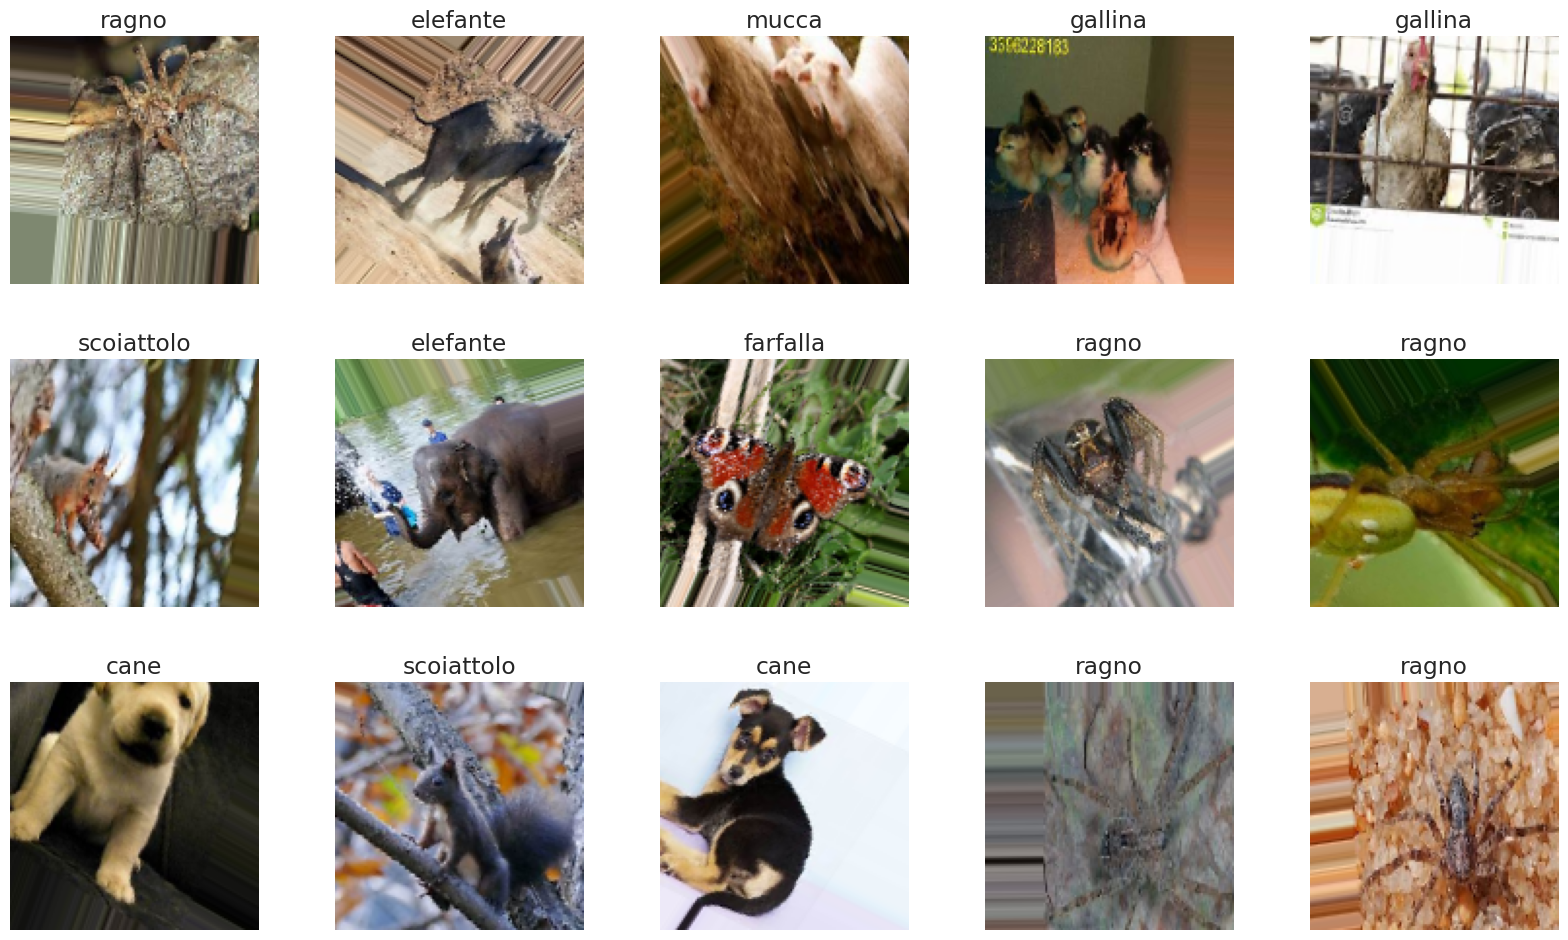

In [14]:
# Step 10: Visualization
label_dict = train_generator.class_indices
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize=(20, 20))

for i in range (15):
	plt.subplot(5, 5, i+1)
	plt.subplots_adjust(hspace=0.3, wspace=0.3)
	plt.imshow(images[i])
	label_index = int(titles[i])
	class_name = list(label_dict.keys())[list(label_dict.values()).index(label_index)]
	plt.title(class_name)
	plt.axis("off")

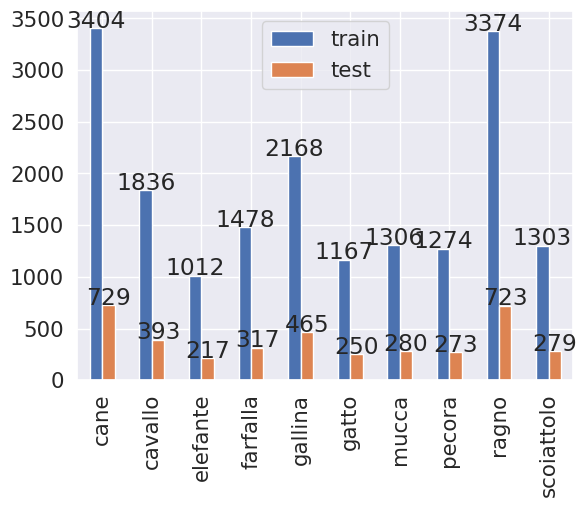

In [15]:
# Step 10: Visualization
import pandas as pd

train_labels = train_generator.classes
test_labels = val_generator.classes
class_names = list(train_generator.class_indices.keys())

train_counts = pd.Series(train_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

df = pd.DataFrame({'train': train_counts, 'test': test_counts})
df.index = class_names

ax = df.plot(kind='bar')
for p in ax.patches:
	ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() /2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

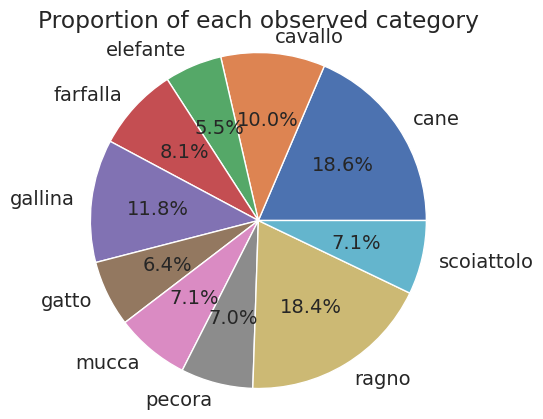

In [16]:
# Step 10: Visualization
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0) , labels=class_names, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()


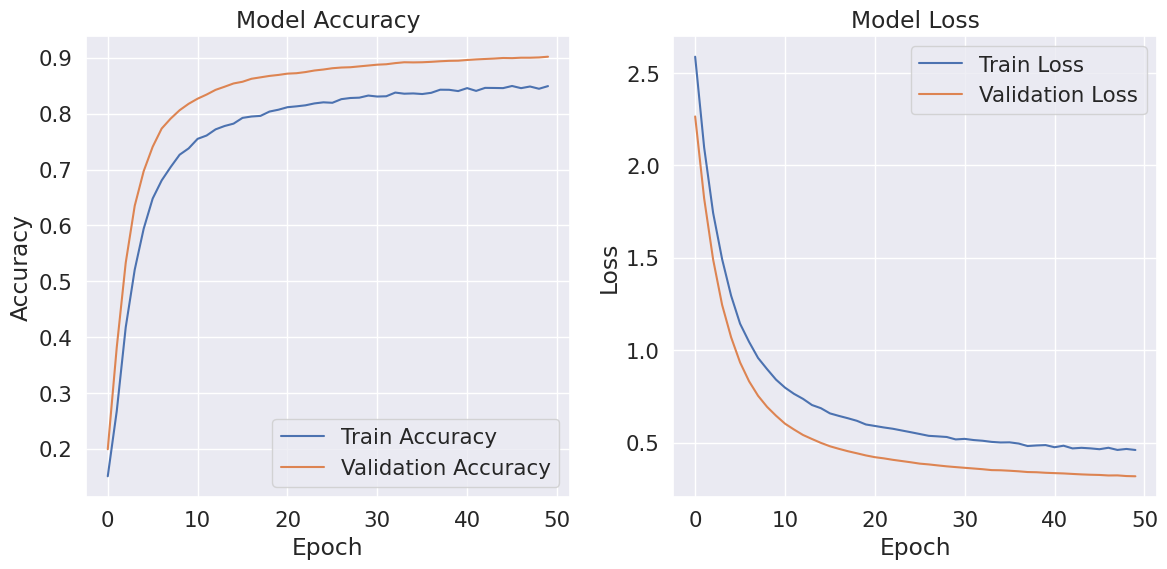

In [11]:
# Step 10: Visualize the Training History
# Accuracy and Loss Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# ** Step 11 **

In [12]:
# Step 11: Save the model
model.save("FinalAnimal_classifier_model.h5")